In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel

%matplotlib inline

In [2]:
# model name
model_name = 'model-2b-lvr'

shuffle_clusters = True

# load the training data
data = DataModel('data-mtx-enough-top-8.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# randomly shuffle the training data
np.random.seed(888)
ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 120:
        return .0003
    elif epoch < 170:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
#TRAINING

In [6]:
%%time
# start the training
ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

17443/17443 [==============================] - 91s 5ms/step - loss: 3.7308 - e_cluster_loss: 0.0375 - p_cluster_loss: 0.0860 - type_loss: 0.2849 - pos_x_loss: 0.0560 - pos_y_loss: 1.0978 - pos_z_loss: 0.0615 - energy_loss: 1.0229 - e_cluster__cluster_accuracy: 0.9492 - p_cluster__cluster_accuracy: 0.8819 - type__type_accuracy: 0.8780 - type__type_tp_rate: 0.8278

CPU times: user 23h 52min 5s, sys: 39min 45s, total: 1d 31min 50s
Wall time: 1d 34min 6s


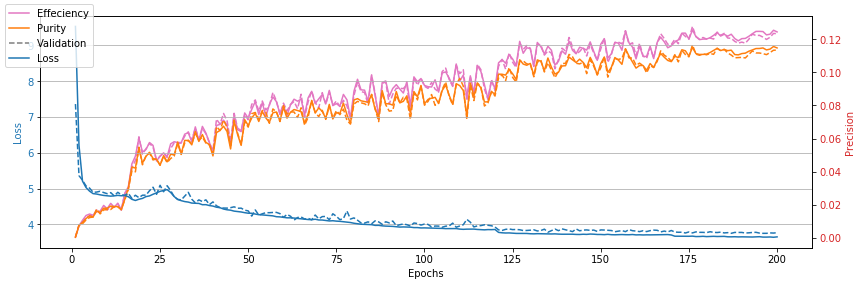

In [7]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [8]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        3.73837
    -Type:         0.28747 *  2.00 = 0.57494
    -Pos X:        0.05410 *  2.50 = 0.13525
    -Pos Y:        1.10376 *  1.00 = 1.10376
    -Pos Z:        0.06340 *  2.00 = 0.12681
    -Energy:       1.02112 *  1.50 = 1.53169
    -Cls e:        0.03832 *  1.00 = 0.03832
    -Cls p:        0.08520 *  1.00 = 0.08520
  Accuracy:    0.87585
    -TP rate:      0.82467
    -Cls e rate:   0.94752
    -Cls p rate:   0.88599
  Efficiency:  0.12396
  Purity:      0.11494
  Euc mean:   11.81333
  Euc std:    30.47915

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [9]:
# save the trained model
ai.save(file_name=model_name)